In [2]:
!pip install tensorflowjs mediapipe --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 67.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have proto

In [3]:
# import libraries
import os
import json
import cv2
import numpy as np
import tensorflow as tf
import tensorflowjs as tfjs
import matplotlib.pyplot as plt
from google.colab import files
from google.colab.patches import cv2_imshow

In [4]:
# uploading model.json, metadata.json, weights.bin
def upload_model_files():
    print("Upload model.json")
    model_json = files.upload()
    model_json_name = list(model_json.keys())[0]

    print("Upload metadata.json")
    metadata_json = files.upload()
    metadata_json_name = list(metadata_json.keys())[0]

    print("Upload weights.bin")
    weights_bin = files.upload()
    weights_bin_name = list(weights_bin.keys())[0]

    if not os.path.exists('model'):
        os.makedirs('model')
    os.rename(model_json_name, 'model/model.json')
    os.rename(metadata_json_name, 'model/metadata.json')
    os.rename(weights_bin_name, 'model/weights.bin')
    return 'model'

In [5]:
# load model and metadata
def load_model(model_dir):
    model = tfjs.converters.load_keras_model(os.path.join(model_dir, 'model.json'))
    with open(os.path.join(model_dir, 'metadata.json'), 'r') as f:
        metadata = json.load(f)
    return model, metadata

# 🧠 Pose keypoint extraction
def detect_pose_keypoints(image_path):
    import mediapipe as mp
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    with mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=False, min_detection_confidence=0.5) as pose:
        results = pose.process(image_rgb)

    if results.pose_landmarks:
        height, width, _ = image.shape
        keypoints = {}
        landmarks = results.pose_landmarks.landmark
        keypoint_names = [
            "nose", "leftEye", "rightEye", "leftEar", "rightEar",
            "leftShoulder", "rightShoulder", "leftElbow", "rightElbow",
            "leftWrist", "rightWrist", "leftHip", "rightHip",
            "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"
        ]
        for i, name in enumerate(keypoint_names):
            if i < len(landmarks):
                keypoints[name] = {
                    "x": landmarks[i].x * width,
                    "y": landmarks[i].y * height,
                    "z": landmarks[i].z,
                    "visibility": landmarks[i].visibility
                }
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        cv2_imshow(annotated_image)
        return keypoints, annotated_image
    else:
        print("No pose detected.")
        return None, None

In [6]:
# prepare model input
def prepare_input(keypoints, metadata):
    input_shape = metadata.get('tensorShape', [1, 14739])
    keypoints_flat = []
    relevant_keypoints = [
        "nose", "leftEye", "rightEye", "leftEar", "rightEar",
        "leftShoulder", "rightShoulder", "leftElbow", "rightElbow",
        "leftWrist", "rightWrist", "leftHip", "rightHip",
        "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"
    ]
    for key in relevant_keypoints:
        if key in keypoints:
            x, y = keypoints[key]["x"], keypoints[key]["y"]
            keypoints_flat.extend([x, y])
        else:
            keypoints_flat.extend([0, 0])

    model_input = np.array(keypoints_flat).reshape(1, -1)
    expected_size = input_shape[1]
    if model_input.shape[1] < expected_size:
        padding = np.zeros((1, expected_size - model_input.shape[1]))
        model_input = np.concatenate([model_input, padding], axis=1)
    elif model_input.shape[1] > expected_size:
        model_input = model_input[:, :expected_size]
    print(f"Prepared input shape: {model_input.shape}")
    return model_input

Upload model.json


Saving model.json to model.json
Upload metadata.json


Saving metadata.json to metadata.json
Upload weights.bin


Saving weights.bin to weights.bin
Upload image:


Saving images.jpeg to images.jpeg


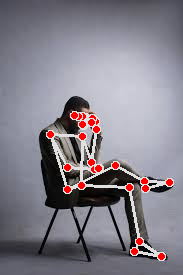

Prepared input shape: (1, 14739)
1/1 [==============================] - 0s 122ms/step

 Prediction Results:
standing: 0.01%
sitting: 99.99%


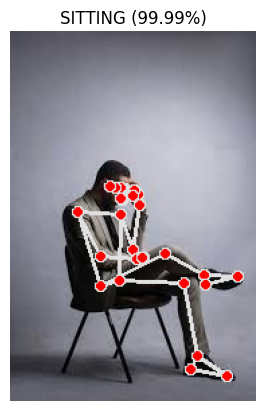


 Detected pose: SITTING with 99.99% confidence


In [7]:
def run_pose_detection():
    model_dir = upload_model_files()
    model, metadata = load_model(model_dir)
    labels = metadata.get('labels', ["standing", "sitting"])

    print("Upload image:")
    uploaded = files.upload()
    if not uploaded:
        print("No image uploaded.")
        return
    image_path = list(uploaded.keys())[0]

    keypoints, annotated_image = detect_pose_keypoints(image_path)
    if keypoints:
        model_input = prepare_input(keypoints, metadata)
        predictions = model.predict(model_input)[0]
        max_index = np.argmax(predictions)
        predicted_label = labels[max_index]
        confidence = predictions[max_index] * 100

        print("\n Prediction Results:")
        for i, label in enumerate(labels):
            print(f"{label}: {predictions[i] * 100:.2f}%")

        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"{predicted_label.upper()} ({confidence:.2f}%)")
        plt.show()

        print(f"\n Detected pose: {predicted_label.upper()} with {confidence:.2f}% confidence")
    else:
        print(" Could not detect pose.")


run_pose_detection()